#### Model and Predictions

In [2]:
# imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, Conv2D, MaxPool2D
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import EarlyStopping
from keras.layers import SimpleRNN, LSTM, GRU, Dense
from keras import backend as K


In [6]:
df = pd.read_csv('data/etsy_shops_clean.csv')

In [7]:
df.head()

,seller_location,seller_join_date,sales_count,number_of_reviews,average_review_score,number_of_items
0,"Soorts-Hossegor, France",2017,14,2.0,4.0000,0
1,"Arizona, United States",2016,137,18.0,5.0000,15
2,"New York, United States",2012,13995,2087.0,4.9218,369
3,"Oklahoma, United States",2012,10,4.0,5.0000,12
4,"Ohio, United States",2019,16,3.0,5.0000,84


In [8]:
X = df.drop(columns = ['sales_count', 'seller_location'])
y = df['sales_count']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22) #train test split the variables

**Null Model** 

In [10]:
# baseline performance is ~30 sales
mean_y_array = np.full_like(y_test, y_test.mean())
np.round(mean_squared_error(y_test, mean_y_array, squared = False), 2)

5892.69

In [11]:
r2_score(y_test, mean_y_array)

-2.08709827198561e-09

**Linear Regression**

In [12]:
pipe_lr = make_pipeline(StandardScaler(), LinearRegression()) #instantiate a pipe with LR

In [13]:
# fit the data
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [14]:
pipe_lr.score(X_train, y_train)

0.8372224896457698

In [15]:
pipe_lr.score(X_test, y_test)

0.8760747464155108

In [16]:
# RMSE
np.round(mean_squared_error(y_test, pipe_lr.predict(X_test), squared = False), 2)

2074.4

**Gradient Boosting Regressor**

In [17]:
pipe_boost = make_pipeline(StandardScaler(), GradientBoostingRegressor())

In [18]:
pipe_boost.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor', GradientBoostingRegressor())])

In [19]:
pipe_boost.score(X_train, y_train)

0.9462578208043686

In [20]:
pipe_boost.score(X_test, y_test)

0.9028770095879654

In [21]:
# RMSE
np.round(mean_squared_error(y_test, pipe_boost.predict(X_test), squared = False), 2)

1836.43

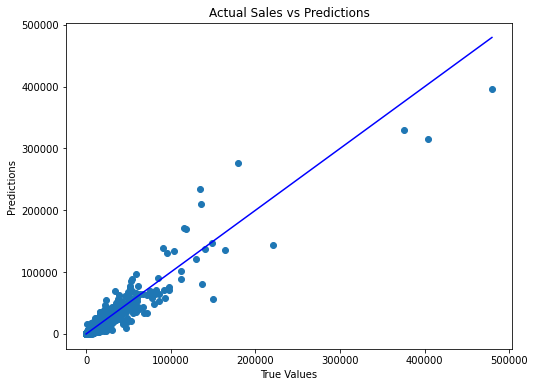

In [22]:
plt.figure(figsize = (8,6))
plt.scatter(y_test, pipe_boost.predict(X_test))
plt.xlabel('True Values', fontsize = 10)
plt.ylabel('Predictions', fontsize = 10) 
p1 = max(max(pipe_boost.predict(X_test)), max(y_test))
p2 = min(min(pipe_boost.predict(X_test)), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Actual Sales vs Predictions');

**Random Forest Regressor**

In [23]:
pipe_forest = make_pipeline(StandardScaler(), RandomForestRegressor()) #instantiate a pipe with RF

In [24]:
# fit the data
pipe_forest.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [25]:
# score on the train data
pipe_forest.score(X_train, y_train)

0.9817718819699222

In [26]:
# score on the train data
pipe_forest.score(X_test, y_test)

0.9055514521678867

In [27]:
# RMSE
np.round(mean_squared_error(y_test, pipe_forest.predict(X_test), squared = False), 4)

1810.97

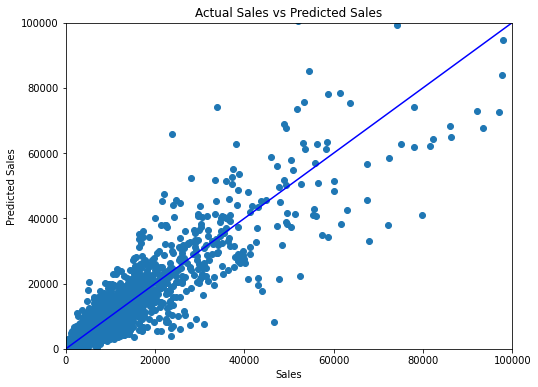

In [28]:
plt.figure(figsize = (8,6))
plt.scatter(y_test, pipe_forest.predict(X_test))
plt.xlabel('Sales', fontsize = 10)
plt.ylabel('Predicted Sales', fontsize = 10) 
plt.xlim(0, 100_000)
plt.ylim(0, 100_000)
# p1 = max(max(pipe_forest.predict(X_test)), max(y_test))
# p2 = min(min(pipe_forest.predict(X_test)), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Actual Sales vs Predicted Sales')
plt.savefig('EDA/charts/Actual vs Predicted Sales');

In [29]:
# feature_importances = pd.DataFrame(pipe_forest.feature_importances_,
#                                    index = X_train.columns,
#                                     columns=['importance']).sort_values('importance', ascending=False)

**Recursive Feature Selection**

In [30]:
# instantiate RFE
rfe_forest = RFE(estimator = RandomForestRegressor(), n_features_to_select = 10, step = 1)

In [31]:
# make pipeline
pipe_rfe_forest = make_pipeline(StandardScaler(), rfe_forest, RandomForestRegressor())

In [32]:
# fit train data into the pipeline
pipe_rfe_forest.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rfe',
                 RFE(estimator=RandomForestRegressor(),
                     n_features_to_select=10)),
                ('randomforestregressor', RandomForestRegressor())])

In [33]:
# coefficient rankings 
rankings_forest = rfe_forest.ranking_

In [34]:
# construct a dataframe with coefficients
rfe_forest_df = pd.DataFrame({'rankings' : rankings_forest, 'names' : X.columns})

In [35]:
# display sorted values
rfe_forest_df.sort_values(by = 'rankings', inplace = True)
rfe_forest_df.head(10)

,rankings,names
0,1,seller_join_date
1,1,number_of_reviews
2,1,average_review_score
3,1,number_of_items


**SVR**

In [36]:
# start a pipe
pipe_svr = make_pipeline(StandardScaler(), SVR())

In [37]:
pipe_svr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())])

In [38]:
pipe_svr.score(X_train, y_train)

0.05992309088137526

In [39]:
pipe_svr.score(X_test, y_test)

0.04972526199675098

In [40]:
# RMSE
np.round(mean_squared_error(y_test, pipe_svr.predict(X_test), squared = False), 2)

5744.31

**Neural Networks**

In [41]:
# instantiate StandardScaler
sscaler = StandardScaler() 

In [42]:
X_train_scaled = sscaler.fit_transform(X_train) #scale X_train

In [43]:
X_test_scaled = sscaler.transform(X_test) #scale X_test

In [44]:
# build a network 
model = Sequential()
model.add(Dense(200, kernel_initializer='normal',input_dim = X_train_scaled.shape[1], activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [45]:
# compile the model
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

In [46]:
# fit the data
history = model.fit( 
    X_train_scaled,
    y_train,
    validation_data = (X_test_scaled, y_test),
    epochs = 35,
    verbose = 0
)

In [47]:
# evaluate the model
nn_model = model.evaluate(X_test_scaled, y_test)

1321/1321 [==============================] - 2s 1ms/step - loss: 3181678.7500 - mse: 3181678.7500A: 1s - loss: 2277474


In [48]:
# rmse of the model with regularization
np.round(np.sqrt(nn_model), 2)

array([1783.73, 1783.73])

In [49]:
predictions = model.predict(X_test_scaled) # make predictions

In [50]:
# r-squared score
r2_score(y_test, predictions)

0.9083717803148076

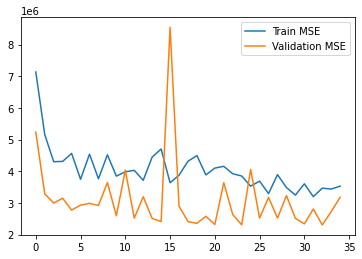

In [51]:
# plot Train and Validation MSE 
plt.plot(history.history['mse'], label = 'Train MSE')
plt.plot(history.history['val_mse'], label = 'Validation MSE')
plt.legend();

**Neural Network # 2**

In [52]:
# build a network 
model2 = Sequential()
model2.add(Dense(500, kernel_initializer='normal',input_dim = X_train_scaled.shape[1], activation='relu'))
model2.add(Dense(256, kernel_initializer='normal',activation='relu'))
model2.add(Dense(100, kernel_initializer='normal',activation='relu'))
model2.add(Dense(50, kernel_initializer='normal',activation='relu'))
model2.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [53]:
# compile the model
model2.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

In [54]:
# fit the data
history2 = model2.fit( 
    X_train_scaled,
    y_train,
    validation_data = (X_test_scaled, y_test),
    epochs = 50,
    verbose = 0
)

In [55]:
# evaluate the model
nn_model2 = model2.evaluate(X_test_scaled, y_test)

1321/1321 [==============================] - 1s 1ms/step - loss: 2645495.5000 - mse: 2645495.5000


In [56]:
# rmse of the model with regularization
np.round(np.sqrt(nn_model2), 2)

array([1626.5, 1626.5])

In [57]:
predictions2 = model2.predict(X_test_scaled) # make predictions

In [58]:
# r-squared score
r2_score(y_test, predictions2)

0.9238131448872854

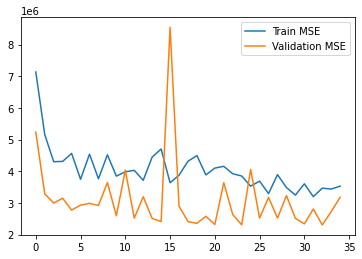

In [59]:
# plot Train and Validation MSE 
plt.plot(history.history['mse'], label = 'Train MSE')
plt.plot(history.history['val_mse'], label = 'Validation MSE')
plt.legend();